Cryoscope

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
from scipy import signal, optimize

In [2]:
def shift_sig( data, range ):
    return data-np.mean(data[range[0]:range[1]])

def norm_sig( data, range ):
    return data/np.mean(data[range[0]:range[1]])


def get_phase( time, data, shift_ref, virtual_detune=0 ):
    rx90_data = data[0][0]
    ry90_data = data[0][1]

    rx90_data = shift_sig(rx90_data, shift_ref )
    ry90_data = shift_sig(ry90_data, shift_ref )
    zdata = (rx90_data + 1j*ry90_data)
    r_zdata = zdata*np.exp(1j*time*virtual_detune/1000*np.pi*2)
    return np.unwrap(np.angle(r_zdata))

def get_detuning_diff( time, data, pad_zeros, virtual_detune=0 ):

    phase = get_phase( time, data, (pad_zeros[0]+10,-10), virtual_detune)
    phase = phase - phase[-1]
    # Filtering and derivative of the phase to get the averaged frequency
    detuning = np.diff(phase / 2 / np.pi *1000)
    dt = time[1]-time[0]
    time = time[:-1] +dt/2
    return time, detuning -virtual_detune

def get_detuning_savgol_filter( time, data, pad_zeros, virtual_detune=0 ):

    phase = get_phase( time, data, (pad_zeros[0]+10,-10), virtual_detune)
    phase = phase - phase[-1]
    # Filtering and derivative of the phase to get the averaged frequency
    detuning = signal.savgol_filter(phase[pad_zeros[0]:] / 2 / np.pi, 11, 3, deriv=1, delta=0.001)
    time = time[pad_zeros[0]:]
    return time, detuning -virtual_detune
    # Flux line step response in freq domain and voltage domain



<xarray.Dataset>
Dimensions:  (mixer: 2, r90: 2, time: 201)
Coordinates:
  * mixer    (mixer) <U1 'I' 'Q'
  * time     (time) int32 -4 0 4 8 12 16 20 24 ... 772 776 780 784 788 792 796
  * r90      (r90) <U1 'x' 'y'
Data variables:
    q0_ro    (mixer, r90, time) float64 ...
    q1_ro    (mixer, r90, time) float64 ...
    q2_ro    (mixer, r90, time) float64 ...
    q3_ro    (mixer, r90, time) float64 ...
    q4_ro    (mixer, r90, time) float64 ...
Attributes:
    start_time:  20240614_153849
    end_time:    20240614_154134


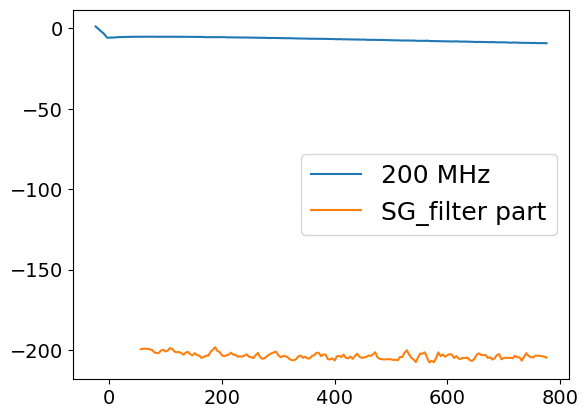

In [3]:
# %matplotlib widget


data_path_list = [r"d:\Data\5Q4C0510_DR1_AS16\cryoscope\20240611_1809_q4_xy_cryoscope_bk.nc",
                  r"d:\Data\5Q4C0510_DR1_AS16\cryoscope\20240611_1814_q4_xy_cryoscope_bk.nc",
                  r"d:\Data\5Q4C0510_DR1_AS16\cryoscope\20240611_1828_q4_xy_cryoscope_bk.nc"]

# data_path_list = [r"d:\Data\5Q4C0510_DR1_AS16\cryoscope\20240611_1809_q4_xy_cryoscope_bk.nc",
#                   r"d:\Data\5Q4C0510_DR1_AS16\cryoscope\20240611_1814_q4_xy_cryoscope_bk.nc"]
# labels = ["200", "300" ]
# data_path_list = [r"d:\Data\5Q4C0510_DR1_AS16\20240611_1809_q4_xy_cryoscope_bk.nc"]
# labels = ["200" ]
# Compare
# data_path_list = [r"d:\Data\5Q4C0510_DR1_AS16\cryoscope\20240611_1828_q4_xy_cryoscope_bk.nc",
#                   r"d:\Data\5Q4C0510_DR1_scalinQ\cryoscope\20240610_2138_q4_xy_cryoscope_bk.nc"]
# labels = ["AS16", "ScalinQ" ]

data_path_list = [r"d:\Data\5Q4C0510_DR1_scalinQ\cryoscope\20240610_2128_q4_xy_cryoscope_bk.nc",
                  r"d:\Data\5Q4C0510_DR1_scalinQ\cryoscope\20240610_2133_q4_xy_cryoscope_bk.nc",
                  r"d:\Data\5Q4C0510_DR1_scalinQ\cryoscope\20240610_2138_q4_xy_cryoscope_bk.nc"]

data_path_list = [r"d:\Data\5Q4C0510_DR1_scalinQ\20240614_1541_q4_xy_cryoscope_cc.nc"]
                  
labels = ["200", "300", "400"]

clabels = ["blue", "orange", "green"]

const_flux_len = 240

pad_zeros = (20,0)



dataset_data = {}
single_ro = "q4_ro"


fig, ax = plt.subplots()

for i, data_path in enumerate(data_path_list):
    dataset = xr.open_dataset(data_path)
    print(dataset)
    virtual_detune = 200
    time = dataset.coords["time"].values
    data = dataset[single_ro].values


    # rx90_data = data[0][0]
    # ry90_data = data[0][1]
    # rx90_data = shift_sig(rx90_data, (20+10,-10) )
    # ry90_data = shift_sig(ry90_data, (20+10,-10) )
    # ax.plot(time-20, rx90_data, label=f"rx90" )
    # ax.plot(time-20, ry90_data, label=f"ry90" )
    # ax.plot(rx90_data, ry90_data, 'o' )
    # ax.set_aspect('equal', 'box')

    phase = get_phase(time, data, (20+10,-10), virtual_detune=virtual_detune)
    ax.plot(time-20, phase, label=f"{labels[i]} MHz" )


    time_diff, detuning_diff = get_detuning_diff(time, data, (20,0), virtual_detune)
    time_sf, detuning_sf = get_detuning_savgol_filter(time, data, (20,0), virtual_detune)
    # ax.plot(time_diff-20, detuning_diff, label=f"diff" )

    ax.plot(time_sf-20, detuning_sf, label=f"SG_filter part" )
    time_sf_0, detuning_sf_0 = get_detuning_savgol_filter(time, data, (0,0), virtual_detune)
    # ax.plot(time_sf_0-20, detuning_sf_0, label=f"SG_filter full" )

    # ax.plot(time_diff-20, detuning_diff, alpha=0.3, color=clabels[i])
    # ax.plot(time_sf-20, detuning_sf, label=f"{labels[i]} MHz", color=clabels[i] )


    norm_detuning_diff = norm_sig(detuning_diff, (-int(const_flux_len / 2),-10))
    norm_detuning_sf = norm_sig(detuning_sf, (-int(const_flux_len / 2),-10))

    # ax.plot(time_diff-20, norm_detuning_diff, alpha=0.5, color=clabels[i])
    # ax.plot(time_sf-20, norm_detuning_sf, label=f"{labels[i]} MHz", color=clabels[i] )
    # ax.set_xlim( 0,240)
    # ax.set_ylim( 0.950, 1.05)
    ax.legend(fontsize=18)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
# fig.legend()
plt.show()




<xarray.Dataset>
Dimensions:  (mixer: 2, r90: 2, time: 201)
Coordinates:
  * mixer    (mixer) <U1 'I' 'Q'
  * time     (time) int32 -4 0 4 8 12 16 20 24 ... 772 776 780 784 788 792 796
  * r90      (r90) <U1 'x' 'y'
Data variables:
    q0_ro    (mixer, r90, time) float64 ...
    q1_ro    (mixer, r90, time) float64 ...
    q2_ro    (mixer, r90, time) float64 ...
    q3_ro    (mixer, r90, time) float64 ...
    q4_ro    (mixer, r90, time) float64 ...
Attributes:
    start_time:  20240614_162438
    end_time:    20240614_163246
<xarray.Dataset>
Dimensions:  (mixer: 2, r90: 2, time: 201)
Coordinates:
  * mixer    (mixer) <U1 'I' 'Q'
  * time     (time) int32 -4 0 4 8 12 16 20 24 ... 772 776 780 784 788 792 796
  * r90      (r90) <U1 'x' 'y'
Data variables:
    q0_ro    (mixer, r90, time) float64 ...
    q1_ro    (mixer, r90, time) float64 ...
    q2_ro    (mixer, r90, time) float64 ...
    q3_ro    (mixer, r90, time) float64 ...
    q4_ro    (mixer, r90, time) float64 ...
Attributes:
    st

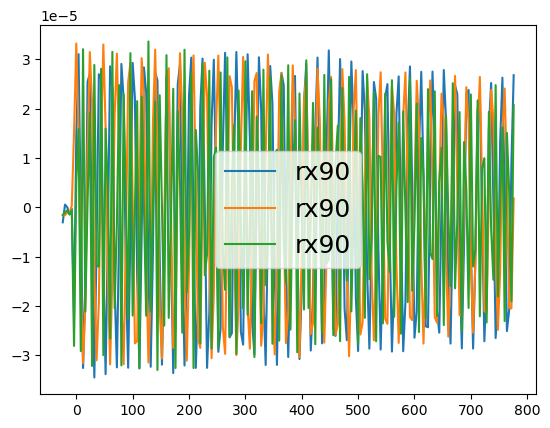

In [4]:
data_path_list = [r"d:\Data\5Q4C0510_DR1_scalinQ\20240614_1632_q4_xy_cryoscope_cc.nc",
                  r"d:\Data\5Q4C0510_DR1_scalinQ\20240614_1649_q4_xy_cryoscope_cc.nc",
                  r"d:\Data\5Q4C0510_DR1_scalinQ\20240614_1700_q4_xy_cryoscope_cc.nc"]


const_flux_len = 240

pad_zeros = (20,0)

virtual_detune = [200,300,400]

dataset_data = {}
single_ro = "q4_ro"

fig, ax = plt.subplots()

for i, data_path in enumerate(data_path_list):
    dataset = xr.open_dataset(data_path)
    print(dataset)
    time = dataset.coords["time"].values
    data = dataset[single_ro].values

    ry90_data = data[0][1]

    ry90_data = shift_sig(ry90_data, (20+10,-10) )
    ax.plot(time-20, ry90_data, label=f"rx90" )
    phase = get_phase(time, data, (20+10,-10), virtual_detune=virtual_detune[i])
    # ax.plot(time-20, phase, label=f"{labels[i]} MHz" )

    time_sf, detuning_sf = get_detuning_savgol_filter(time, data, (6,0), virtual_detune[i])
    norm_detuning_sf = norm_sig(detuning_sf, (-int(const_flux_len / 2),-10))

    # ax.plot(time_sf-20, norm_detuning_sf, label=f"AS16" )

# ax.set_xlim( 0,50)
# ax.set_ylim( 0.850, 1.05)
ax.legend(fontsize=18)

<xarray.Dataset>
Dimensions:  (mixer: 2, r90: 2, time: 201)
Coordinates:
  * mixer    (mixer) <U1 'I' 'Q'
  * time     (time) int32 -4 0 4 8 12 16 20 24 ... 772 776 780 784 788 792 796
  * r90      (r90) <U1 'x' 'y'
Data variables:
    q0_ro    (mixer, r90, time) float64 ...
    q1_ro    (mixer, r90, time) float64 ...
    q2_ro    (mixer, r90, time) float64 ...
    q3_ro    (mixer, r90, time) float64 ...
    q4_ro    (mixer, r90, time) float64 ...
Attributes:
    start_time:  20240614_162438
    end_time:    20240614_163246
<xarray.Dataset>
Dimensions:  (mixer: 2, r90: 2, time: 201)
Coordinates:
  * mixer    (mixer) <U1 'I' 'Q'
  * time     (time) int32 -4 0 4 8 12 16 20 24 ... 772 776 780 784 788 792 796
  * r90      (r90) <U1 'x' 'y'
Data variables:
    q0_ro    (mixer, r90, time) float64 ...
    q1_ro    (mixer, r90, time) float64 ...
    q2_ro    (mixer, r90, time) float64 ...
    q3_ro    (mixer, r90, time) float64 ...
    q4_ro    (mixer, r90, time) float64 ...
Attributes:
    st

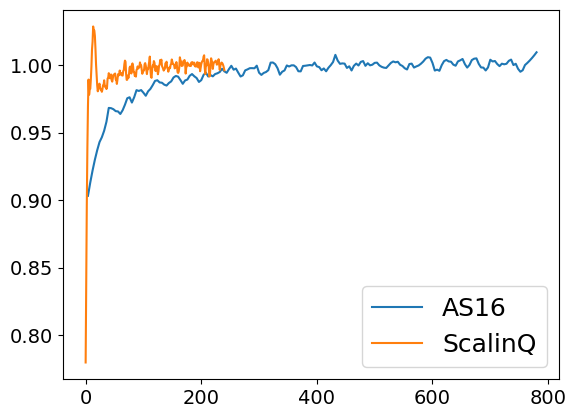

In [5]:
# %matplotlib widget


data_path_list = [r"d:\Data\5Q4C0510_DR1_scalinQ\20240614_1632_q4_xy_cryoscope_cc.nc",
                  r"d:\Data\5Q4C0510_DR1_scalinQ\20240614_1649_q4_xy_cryoscope_cc.nc",
                  r"d:\Data\5Q4C0510_DR1_scalinQ\20240614_1700_q4_xy_cryoscope_cc.nc"]


const_flux_len = 240

virtual_detune = [200,300,400]

dataset_data = {}
single_ro = "q4_ro"

norm_detuning_sf_AS16 = []
for i, data_path in enumerate(data_path_list):
    dataset = xr.open_dataset(data_path)
    print(dataset)
    time = dataset.coords["time"].values
    data = dataset[single_ro].values

    time_sf_0, detuning_sf = get_detuning_savgol_filter(time, data, (6,0), virtual_detune[i])
    norm_detuning_sf = norm_sig(detuning_sf, (-int(const_flux_len / 2),-10))
    norm_detuning_sf_AS16.append(norm_detuning_sf)

# fig.legend()

data_path_list = [r"d:\Data\5Q4C0510_DR1_scalinQ\cryoscope\20240610_2128_q4_xy_cryoscope_bk.nc",
                  r"d:\Data\5Q4C0510_DR1_scalinQ\cryoscope\20240610_2133_q4_xy_cryoscope_bk.nc",
                  r"d:\Data\5Q4C0510_DR1_scalinQ\cryoscope\20240610_2138_q4_xy_cryoscope_bk.nc"]


norm_detuning_sf_SQ = []
for i, data_path in enumerate(data_path_list):
    dataset = xr.open_dataset(data_path)
    print(dataset)
    virtual_detune = 200
    time = dataset.coords["time"].values
    data = dataset[single_ro].values

    time_sf, detuning_sf = get_detuning_savgol_filter(time, data, (20,0), virtual_detune)
    norm_detuning_sf = norm_sig(detuning_sf, (-int(const_flux_len / 2),-10))
    norm_detuning_sf_SQ.append(norm_detuning_sf)


norm_detuning_sf_AS16 = np.mean( np.array(norm_detuning_sf_AS16), axis=0 )
norm_detuning_sf_SQ = np.mean( np.array(norm_detuning_sf_SQ), axis=0 )
fig, ax = plt.subplots()
ax.plot(time_sf_0-16, norm_detuning_sf_AS16, label=f"AS16" )
ax.plot(time_sf-20, norm_detuning_sf_SQ, label=f"ScalinQ" )

# ax.set_xlim( 0,50)
# ax.set_ylim( 0.850, 1.05)
ax.legend(fontsize=18)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.show()


